In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../Environment/Version3_1')
from rl_mh import RLMHEnv
from mcmctoolbox.functoolbox import flat

from tqdm.auto import trange

import toml
from types import SimpleNamespace

import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

config = toml.load("../Jax/rlmcmc/config/ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

import logging
logging.basicConfig(filename="DDPG_single.log", level=logging.INFO)

# Log to Tensorboard
from torch.utils.tensorboard import SummaryWriter
import time

writer = SummaryWriter(f"runs/V3/{str(time.time())}")

In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(24)(x)
        x = nn.softplus(x)
        x = nn.Dense(12)(x)
        x = nn.softplus(x)
        x = nn.Dense(8)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        return x

In [3]:
class Actor(nn.Module):
    sample_dim: int

    @nn.compact
    def __call__(self, obs: jnp.ndarray):
        """
        Mu function
        """
        x, mcmc_noise = jnp.split(obs, [self.sample_dim], axis=1)
        x_star = self.gene_x_star(x, mcmc_noise)

        cov_x_flatten = self.cov(x).reshape(-1, 2*self.sample_dim)
        cov_x_star_flatten = self.cov(x_star).reshape(-1, 2*self.sample_dim)

        return jnp.hstack([cov_x_flatten, cov_x_star_flatten])

    def setup(self):
        self.dense1 = nn.Dense(24)
        self.dense2 = nn.Dense(12)
        self.dense3 = nn.Dense(8)
        self.dense_output = nn.Dense(self.sample_dim + 1, use_bias=True)

    def low_rank_vec_and_mag(self, x):
        x = self.dense1(x)
        x = nn.softplus(x)
        x = self.dense2(x)
        x = nn.softplus(x)
        x = self.dense3(x)
        x = nn.softplus(x)
        x = self.dense_output(x)
        return x

    def cov(self, x):
        """
        Restored low rank vector and magnification to covariance matrix.
        i.e. [1.0, 0.0, 0.0, 1.0, 2.0] -> [[1.0, 0.0], [0.0, 1.0]] + `2.0` * I -> [[3.0, 0.0], [0.0, 3.0]]
        """
        low_rank_vec, mag = jnp.split(
            self.low_rank_vec_and_mag(x), [self.sample_dim], axis=1
        )

        return (
            low_rank_vec[:, :, None] * low_rank_vec[:, None, :]
            + mag[:, :, None]**2 * jnp.eye(self.sample_dim )[None, :, :]
        )  # Outer Product

    def gene_x_star(self, x, mcmc_noise):
        return x + jnp.einsum('ij,ijk->ik', mcmc_noise, jnp.linalg.cholesky(self.cov(x)))


In [4]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [5]:
# Load DataBase Locally
pdb_path = "/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-banana-test-banana")
stan_code = posterior.model.stan_code_file_path()
stan_data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_code, stan_data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density


In [6]:
# Setup env
sample_dim = 2
action_dim = 2 * sample_dim**2
state_dim = sample_dim * 2

total_timesteps=100_000
args.total_timesteps = total_timesteps
args.batch_size = 24

env = RLMHEnv(
    log_target_pdf=log_p,
    sample_dim=sample_dim,
    total_timesteps=total_timesteps
    )
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False
)

In [7]:
# Start
obs, _ = env.reset(seed=args.seed)
actor = Actor(sample_dim=sample_dim)
qf1 = QNetwork()

In [8]:
args.learning_rate = 1e-5

In [9]:
actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
) # theta

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
) # q

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

In [10]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    # next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)
    next_state_actions = actor.apply(actor_state.target_params, next_observations)
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    logging.info("update_critic grads:", grads)

    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)

    logging.info("update_actor grads:", grads)

    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value

In [11]:
for global_step in trange(args.total_timesteps):
    actions = actor.apply(actor_state.params, obs)

    writer.add_scalars('mcmc/trace_plot', {'x': obs[:, 0].item(), 'y': obs[:, 1].item()}, global_step)

    # actions = (np.array(actions) + np.random.normal(0, args.exploration_noise)).clip(
    #                 env.action_space.low, env.action_space.high
    #             )

    next_obs, rewards, terminateds, truncateds, infos = env.step(np.array(actions, dtype=np.float64))
    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state=actor_state,
            qf1_state=qf1_state,
            observations=data.observations.reshape(-1, state_dim).numpy(),
            actions=data.actions.numpy(),
            next_observations=data.next_observations.reshape(-1, state_dim).numpy(),
            rewards=data.rewards.flatten().numpy(),
            dones=data.dones.flatten().numpy()
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state=actor_state,
                qf1_state=qf1_state,
                observations=data.observations.reshape(-1, state_dim).numpy(),
            )

        if global_step > args.policy_frequency:
            writer.add_scalar("losses/qf1_loss", qf1_loss_value.item(), global_step)
            writer.add_scalar("losses/qf1_values", qf1_a_values.item(), global_step)
            writer.add_scalar("losses/actor_loss", actor_loss_value.item(), global_step)
            writer.add_scalar("rewards/rewards", rewards.item(), global_step)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
state_list = np.array([i for i in env.store_state]).reshape(-1, state_dim)
action_list = np.array([i for i in env.store_action]).reshape(-1, action_dim)

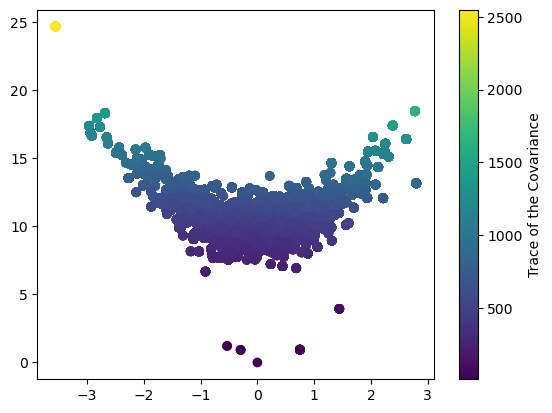

In [13]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
sc = ax.scatter(state_list[1:, 0], state_list[1:, 1], c=(action_list[:, 0] + action_list[:, 3]), cmap='viridis')

plt.colorbar(sc, label='Trace of the Covariance')

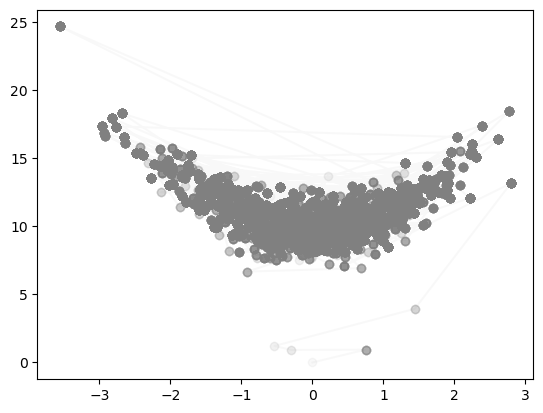

In [14]:
plt.plot(state_list[1:, 0], state_list[1:, 1], 'o-', color='grey', alpha=0.05)

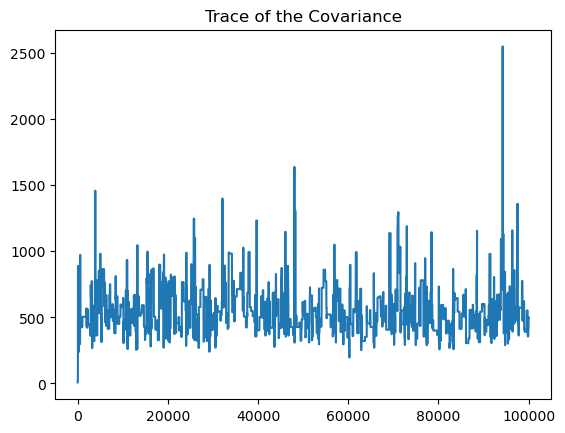

In [15]:
plt.plot(action_list[:, 0] + action_list[:, 3])
plt.title("Trace of the Covariance")
plt.show()

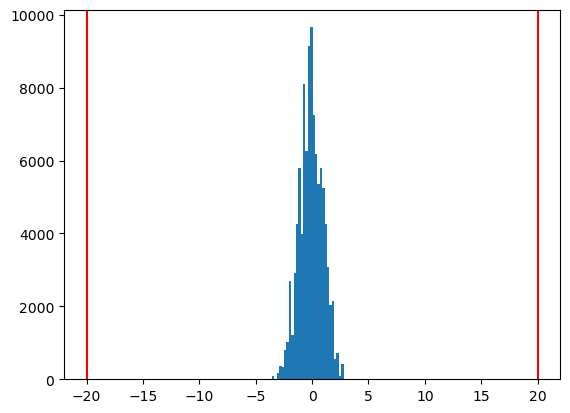

In [16]:
plt.hist(state_list[:, 0], bins=30)
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


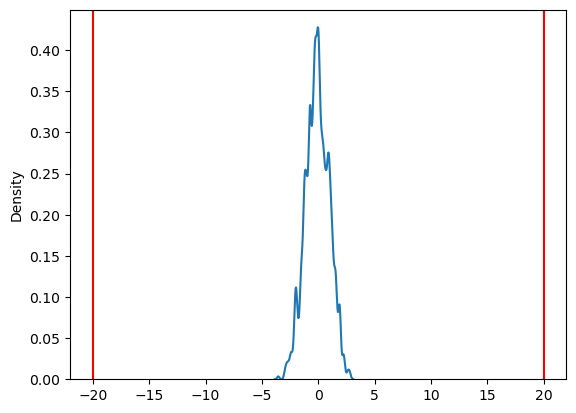

In [17]:
import seaborn as sns

sns.kdeplot(state_list[:, 0])
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

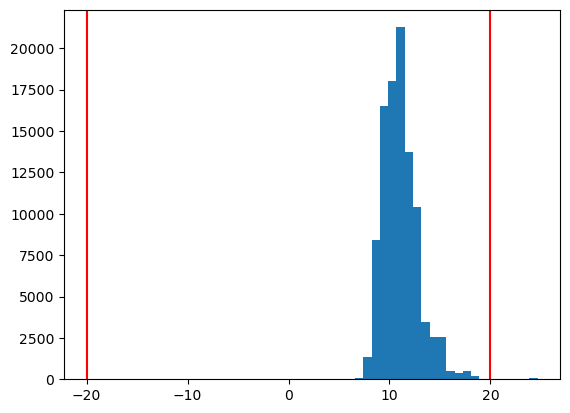

In [18]:
plt.hist(state_list[:, 1], bins=30)
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


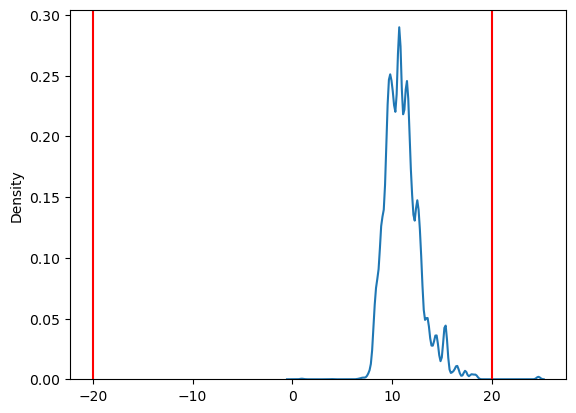

In [19]:
sns.kdeplot(state_list[:, 1])
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

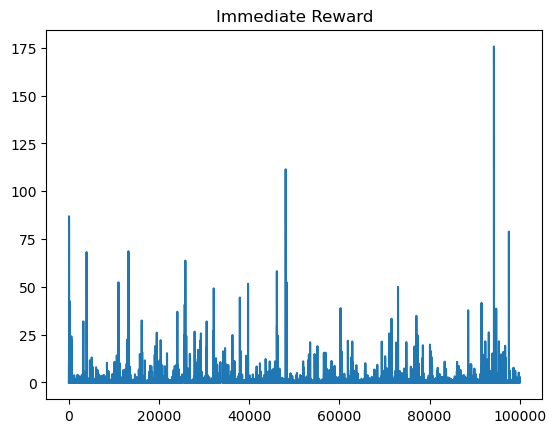

In [20]:
plt.plot(env.store_reward)
plt.title("Immediate Reward")
plt.show()

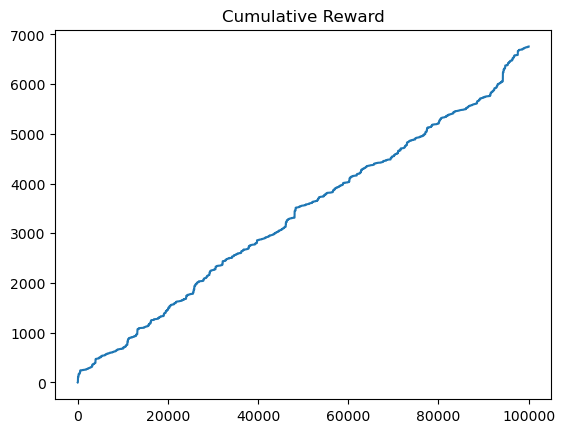

In [21]:
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward")
plt.show()

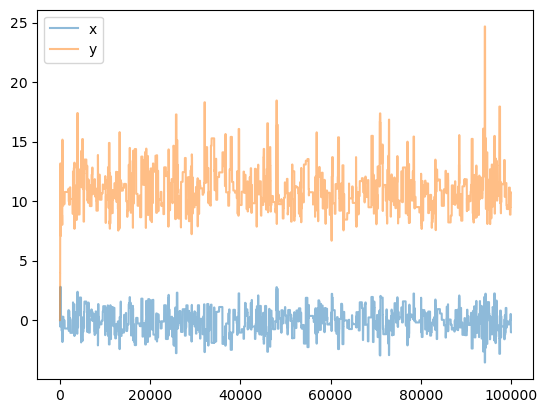

In [22]:
plt.plot(state_list[:, 0], label="x", alpha=0.5)
plt.plot(state_list[:, 1], label="y", alpha=0.5)
plt.legend()
plt.show()

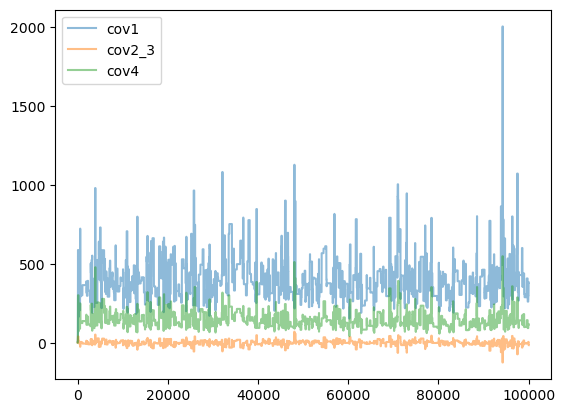

In [23]:
plt.plot(action_list[:, 0], label="cov1", alpha=0.5)
plt.plot(action_list[:, 1], label="cov2_3", alpha=0.5)
plt.plot(action_list[:, 3], label="cov4", alpha=0.5)
plt.legend()
plt.show()

In [24]:
np.sum(env.store_accetped_status)/len(env.store_accetped_status)

0.007709922900770993

In [25]:
import pandas as pd
df = pd.DataFrame(
    np.hstack(
        [
    state_list[1:, 0:2],
    action_list[:, 0:4],
    np.array(env.store_reward).reshape(-1, 1)[1:],
    np.array(env.store_log_accetance_rate).reshape(-1, 1)[1:],
    np.array(env.store_accetped_status).reshape(-1, 1)[1:]
        ]
    ),
    columns=['x', 'y', 'cov1', 'cov2', 'cov3', 'cov4', 'rewards', 'log_alpha', 'accepted_status']
)
# Find the row with the largest value in the 'rewards' column
max_rewards_row = df.loc[
    [
        df['rewards'].idxmax() - 4,
        df['rewards'].idxmax() - 3,
        df['rewards'].idxmax() - 2,
        df['rewards'].idxmax() - 1,
        df['rewards'].idxmax(),
        df['rewards'].idxmax() + 1,
        df['rewards'].idxmax() + 2,
        df['rewards'].idxmax() + 3,
        df['rewards'].idxmax() + 4
    ]
]

max_rewards_row

,x,y,cov1,cov2,cov3,cov4,rewards,log_alpha,accepted_status
94260,-3.552981,24.668087,2001.292114,-123.301750,-123.301750,548.293335,0.000000e+00,-2.237261e+06,0.0
94261,-3.552981,24.668087,2001.292114,-123.301750,-123.301750,548.293335,0.000000e+00,-1.435680e+07,0.0
94262,-3.552981,24.668087,2001.292114,-123.301750,-123.301750,548.293335,0.000000e+00,-5.198182e+06,0.0
94263,-3.552981,24.668087,2001.292114,-123.301750,-123.301750,548.293335,0.000000e+00,-2.102648e+06,0.0
94264,1.206607,12.296729,2001.292114,-123.301750,-123.301750,548.293335,1.757042e+02,0.000000e+00,1.0
94265,1.206607,12.296729,500.413544,19.938438,19.938438,210.331985,0.000000e+00,-2.213077e+05,0.0
94266,1.206607,12.296729,500.413544,19.938438,19.938438,210.331985,0.000000e+00,-3.576235e+03,0.0
94267,1.206607,12.296729,500.413544,19.938438,19.938438,210.331985,0.000000e+00,-2.224698e+05,0.0
94268,1.206607,12.296729,500.413544,19.938438,19.938438,210.331985,6.410588e-32,-7.649892e+01,0.0


In [26]:
obs
obs_list = []
for i in trange(5_000):
    actions = actor.apply(actor_state.params, obs)

    obs, rewards, terminateds, truncateds, infos = env.step(np.array(actions, dtype=np.float64))
    obs_list.append(obs)

  0%|          | 0/5000 [00:00<?, ?it/s]

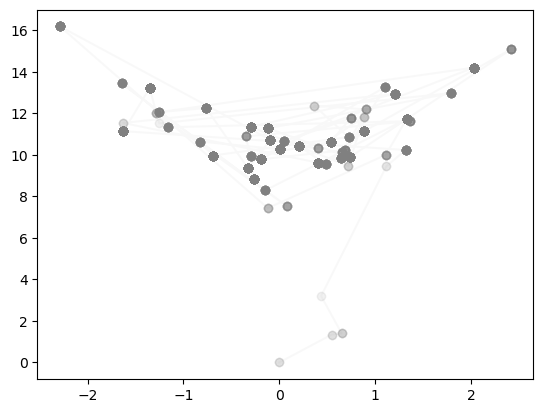

In [27]:
obs_list = np.array(obs_list).reshape(-1, state_dim)
plt.plot(obs_list[1:, 0], obs_list[1:, 1], 'o-', color='grey', alpha=0.05)